In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Trading simulator

## Overview of libraries

The code below is meant to give an impression of the current implementation of the libraries that are customly developed for the algorithmic trading algorithm.

### Imports

In [2]:
import poloniex as plnx
import ta_lib as ta
from datetime import datetime, timedelta
from matplotlib.finance import candlestick2_ohlc

### Chart settings

In [3]:
pair = 'USDT_BTC'
timeframe = 30*60
end = datetime.utcnow()
start = end - timedelta(days=4)

In [4]:
chart = plnx.get_chart(pair, timeframe, start, end)

### Technical indicators

In [5]:
ta.daily_returns(chart)
ta.ema(chart)    # default n=7
ta.ema(chart, 23)
ta.bbands(chart) # default n=20
ta.rsi(chart)    # default n=14

### Plotting

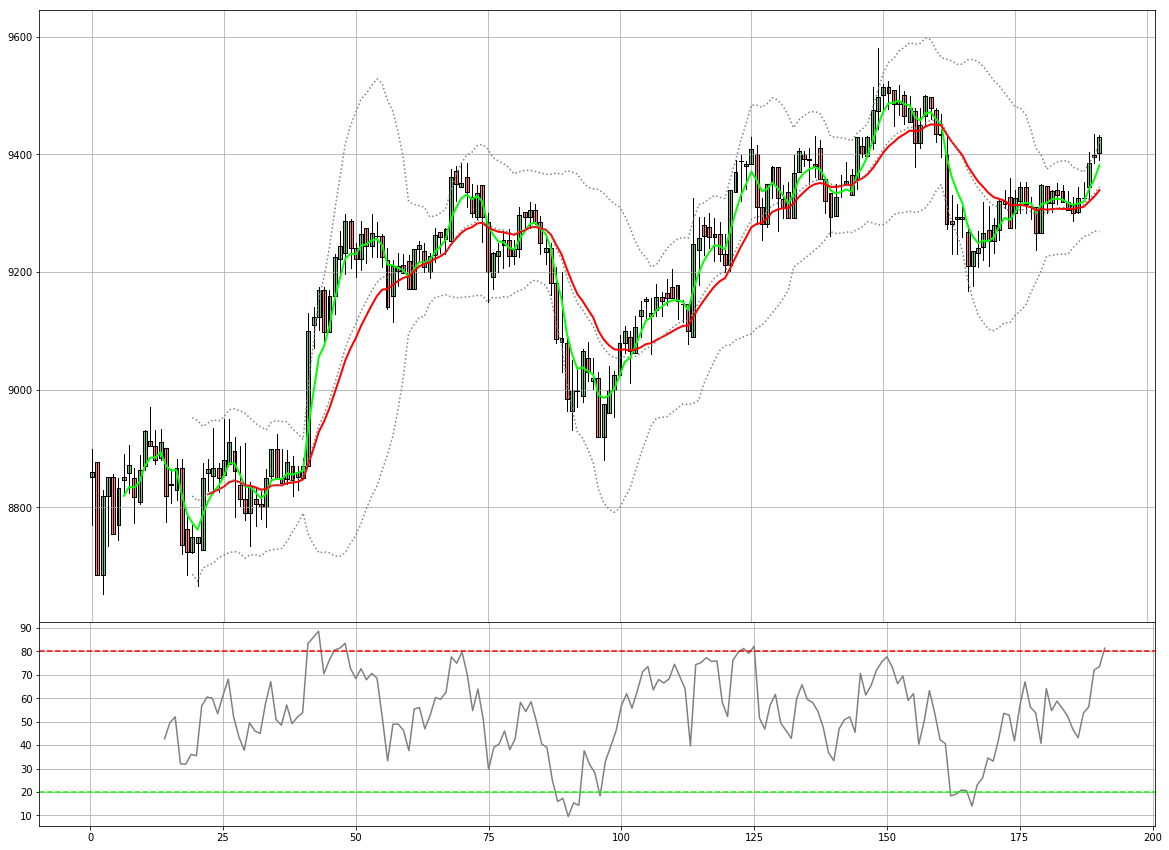

In [6]:
from matplotlib import gridspec

gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
f = plt.figure(figsize=(20,15))
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
candlestick2_ohlc(ax1, chart['open'], chart['high'], chart['low'], chart['close'], width=0.74, colorup='g', colordown='r', alpha=0.5)
ax1.plot(chart['ema7'], c='lime', lw=2)
ax1.plot(chart['ema23'], c='red', lw=2)
ax1.plot(chart['bb_mid'], c='gray', ls='dotted')
ax1.plot(chart['bb_upper'], c='gray', ls='dotted')
ax1.plot(chart['bb_lower'], c='gray', ls='dotted')
ax1.grid()
ax2.plot(list(chart.index), chart['rsi'], c='gray')
ax2.grid()
ax2.axhline(y=80, c='red', ls='dashed')
ax2.axhline(y=20, c='lime', ls='dashed')
ax2.fill_between(list(chart.index), 20, 80, color='grey', alpha=0) # 'kinda' corrects the x-axis for RSI 
f.subplots_adjust(hspace=0)

### Data columns

In [7]:
chart.columns

Index(['close', 'date', 'high', 'low', 'open', 'daily_return', 'ema7', 'ema23',
       'bb_mid', 'bb_upper', 'bb_lower', 'rsi'],
      dtype='object')

### Dataset

In [8]:
chart[20:25]

,close,date,high,low,open,daily_return,ema7,ema23,bb_mid,bb_upper,bb_lower,rsi
20,8750.000000,2018-04-26 11:30:00,8750.000000,8666.000000,8739.460000,0.000000,8762.131088,NaN,8810.990758,8947.460888,8674.520628,35.488039
21,8850.000000,2018-04-26 12:00:00,8876.223776,8727.544435,8727.544435,100.000000,8787.963082,NaN,8817.174981,8937.546360,8696.803601,56.734198
22,8864.655565,2018-04-26 12:30:00,8881.794453,8827.610994,8859.248691,14.655565,8810.511936,8822.343293,8822.537419,8943.693286,8701.381552,60.510445
23,8867.080000,2018-04-26 13:00:00,8935.300000,8824.615728,8853.069516,2.424435,8826.554558,8826.317334,8827.210322,8949.069449,8705.351196,60.003080
24,8850.110679,2018-04-26 13:30:00,8875.874887,8826.906467,8867.080000,-16.969321,8836.682072,8830.408007,8830.829083,8946.828252,8714.829914,53.380654


## Specification

Specifications for the trading simulator.

### Simulation parameters

We want to be able to adjust the following parameters for the simulation:

1. Symbol 
2. Timeframe
3. Stop loss strategy: `none`, `limit`, `trail`
4. Stop loss percentage (max losses before the trade is stopped out)
5. Amount of leverage used
6. Fee percentage per order
7. Initial balance
8. Lot sizing
9. Signals, when to go long and short

### Simulation metrics

We want to able to track the following metrics:

1. Total trades
2. Winning trades
3. Losing trades
4. Win/loss ratio
5. Trades stopped out
6. Fee paid
7. Fee paid (cumulative)
8. Gains
9. Gains (cumulative)
10. Drawdown
11. Max drawdown
12. Risk/reward ratio 
13. Risk/reward average

### Simulation types

We want to support the following simulation types:

1. Single simulation
2. Multiple simulations for parameter tuning

## Implementation

### Trade

We want a `Trade` class that keeps track of:

 * State (`open`, `closed`, `stopped`, `submitted`, `timed_out`, `expired`)
 * Expiry time, if an order expires we want to resubmit a limit order for a new price.
 * Lot size
 * Entry price
 * Exit price
 * P/L
 * P/L in %
 * Stop loss type (`none`, `limit`, `trail`)
 * Stop loss percentage
 * Stop loss price
 * Fees
 * Leverage
 * Net result (P/L adjusted with fees)
 * Entry date
 * Exit date
 * Trade open (hours)

In [9]:
class Trade():
    exit_price = None      # Price when the trade was closed.
    stop_loss_price = None # Price when the stop loss should trigger.
    
    """ Initialize a new order. """
    def __init__(self, position_type, lot_size, leverage, entry_price, stop_loss, stop_loss_percentage, fee_percentage):
        self.state = 'open'
        self.position_type = position_type
        self.lot_size_base = lot_size
        self.lot_size_base_leveraged = lot_size * leverage
        self.lot_size_quote = lot_size / entry_price
        self.lot_size_quote_leveraged = lot_size / entry_price * leverage
        self.leverage = leverage
        self.entry_price = entry_price
        self.stop_loss = stop_loss
        self.stop_loss_percentage = stop_loss_percentage
        self.fee_percentage = fee_percentage
        self.stop_loss_price = (1 - stop_loss_percentage) * entry_price if position_type == 'long' \
                          else (1 + stop_loss_percentage) * entry_price # is short
    
    """ Returns the total order cost in the base currency. """
    def order_cost(self):
        return self.lot_size_base * self.leverage
    
    """ Returns the market value of the order in the base currency. """
    def market_value(self):
        x = self.exit_price if self.exit_price != None else self.current_price
        return self.lot_size_quote * x * self.leverage
    
    """ Returns the P/L for this in the base currency. """
    def pl(self):
        x = self.exit_price if self.exit_price != None else self.current_price
        if self.position_type == 'long':  return self.market_value() - self.order_cost()
        if self.position_type == 'short': return self.order_cost() - self.market_value()
                                         
    """ Returns the P/L percentage. """
    def pl_percent(self):
        x = self.exit_price if self.exit_price != None else self.current_price
        if self.position_type == 'long':  return x / self.entry_price
        if self.position_type == 'short': return self.entry_price / x
        
    """ Returns the paid fees in the base currency. """
    def paid_fees(self):
        entry_fee = self.lot_size_base * self.leverage * self.fee_percentage
        exit_fee = self.lot_size_quote * self.leverage * self.exit_price * self.fee_percentage
        return entry_fee + exit_fee
    
    """ Closes the order on the current price. """
    def close(self):
        if self.state == 'stopped': return # order is already closed, and exit price is set 
                                           # for that stop loss level.
        self.exit_price = self.current_price
        self.state = 'closed'
    
    """ Closes the order on the stop loss price. """
    def stop(self):
        self.exit_price = self.stop_loss_price
        self.state = 'stopped'

    """ Update current price, this should be called before using any other method. """
    def update_price(self, current_price):
        self.current_price = current_price
        if self.stop_loss_hit(): 
            self.stop()

    """ Returns true if the stop loss price is hit. """
    def stop_loss_hit(self):
        if self.position_type == 'long':  return self.current_price < self.stop_loss_price 
        if self.position_type == 'short': return self.current_price > self.stop_loss_price

    """ Statistical information. """
    def statistics(self):
        print('state:                    {}'.format(self.state))
        print('position_type:            {}'.format(self.position_type))
        print('lot_size_base:            {}'.format(self.lot_size_base))
        print('lot_size_base_leveraged:  {}'.format(self.lot_size_base_leveraged))
        print('lot_size_quote:           {}'.format(self.lot_size_quote)) 
        print('lot_size_quote_leveraged: {}'.format(self.lot_size_quote_leveraged)) 
        print('leverage:                 {}'.format(self.leverage))
        print('entry_price:              {}'.format(self.entry_price))
        print('exit_price:               {}'.format(self.exit_price))
        print('fee_percentage:           {}'.format(self.fee_percentage))
        print('stop_loss:                {}'.format(self.stop_loss))
        print('stop_loss_percentage:     {}'.format(self.stop_loss_percentage))
        print('stop_loss_price:          {}'.format(self.stop_loss_price))
        print('order_cost():             {}'.format(self.order_cost()))
        print('market_value():           {}'.format(self.market_value()))
        print('pl():                     {}'.format(self.pl()))
        print('pl_percent():             {}'.format(self.pl_percent()))
        print('paid_fees():              {}'.format(self.paid_fees()))

In [10]:
position_type = 'long'
lot_size = 10
leverage = 10
current_price = 500
stop_loss = 'limit'
stop_loss_percentage = 0.01
fee_percentage = 0.00075

trade1 = Trade(position_type, lot_size, leverage, current_price, stop_loss, stop_loss_percentage, fee_percentage)
trade1.update_price(750)
trade1.close()
trade1.statistics()

state:                    closed
position_type:            long
lot_size_base:            10
lot_size_base_leveraged:  100
lot_size_quote:           0.02
lot_size_quote_leveraged: 0.2
leverage:                 10
entry_price:              500
exit_price:               750
fee_percentage:           0.00075
stop_loss:                limit
stop_loss_percentage:     0.01
stop_loss_price:          495.0
order_cost():             100
market_value():           150.0
pl():                     50.0
pl_percent():             1.5
paid_fees():              0.1875


In [11]:
position_type = 'short'
lot_size = 1
leverage = 1
current_price = 1000
stop_loss = 'limit'
stop_loss_percentage = 0.01
fee_percentage = 0.00075

trade2 = Trade(position_type, lot_size, leverage, current_price, stop_loss, stop_loss_percentage, fee_percentage)
trade2.update_price(500)
trade2.close()
trade2.statistics()

state:                    closed
position_type:            short
lot_size_base:            1
lot_size_base_leveraged:  1
lot_size_quote:           0.001
lot_size_quote_leveraged: 0.001
leverage:                 1
entry_price:              1000
exit_price:               500
fee_percentage:           0.00075
stop_loss:                limit
stop_loss_percentage:     0.01
stop_loss_price:          1010.0
order_cost():             1
market_value():           0.5
pl():                     0.5
pl_percent():             2.0
paid_fees():              0.0011250000000000001


!! PL() should yield `1000.0`

In [12]:
position_type = 'short'
lot_size = 1000
leverage = 1
current_price = 1000
stop_loss = 'limit'
stop_loss_percentage = 0.01
fee_percentage = 0.00075

trade3 = Trade(position_type, lot_size, leverage, current_price, stop_loss, stop_loss_percentage, fee_percentage)
trade3.update_price(1250)
trade3.statistics()

state:                    stopped
position_type:            short
lot_size_base:            1000
lot_size_base_leveraged:  1000
lot_size_quote:           1.0
lot_size_quote_leveraged: 1.0
leverage:                 1
entry_price:              1000
exit_price:               1010.0
fee_percentage:           0.00075
stop_loss:                limit
stop_loss_percentage:     0.01
stop_loss_price:          1010.0
order_cost():             1000
market_value():           1010.0
pl():                     -10.0
pl_percent():             0.9900990099009901
paid_fees():              1.5075
